# ML Assignment 2 : Neural Networks
## Anirudh Agrawal: 2018A7PS0099H | Aviral Agrawal: 2018A70192H | Vikramjeet Das: 2018A7PS0280H

In [1]:
import numpy as np
import pandas as pd
from ANN.Layers import Dense, Activation
from ANN.Model import Model
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
plt.style.use('dark_background')
%matplotlib inline

In [2]:
data = pd.read_csv('dataset_NN.csv')

In [3]:
data.head()

,att1,att2,att3,att4,att5,att6,class
0,1.0,0.0,0.0,133.150861,1.311693,1620.221779,1
1,1.0,0.0,0.0,126.724861,1.302745,1609.334822,1
2,1.0,0.0,0.0,131.173861,1.319031,1568.978435,1
3,1.0,0.0,0.0,129.478861,1.270878,1695.055281,1
4,1.0,0.0,0.0,127.262861,1.329637,1647.720235,1


In [4]:
def shuffle(X, y):
    '''
        Shuffles rows of a dataframe and returns shuffled dataframe
    '''
    permute = np.random.permutation(len(X))
    return X[permute], y[permute]

In [5]:
class MinMaxScaler():
    '''
        Class to normalize a pandas dataframe
    '''
    def fit(self, X):
        self.X = X
        self.min = X.min(axis = 0)
        self.max = X.max(axis = 0)
        
    def fit_transform(self, X):
        self.X = X
        self.fit(X)
        return self.transform(X)
    
    def transform(self, X):
        if (isinstance(X, np.ndarray)):
            return ((X - np.array(self.min)) / (np.array(self.max) - np.array(self.min)))
        return (X - self.min) / (self.max - self.min)
        
    def get_params():
        return self.min, self.max

In [6]:
def train_test_split(X, y, test_size=0.3):
    '''
        Splits data into train-test split
            
            Parameters:
                X : Features
                y : Labels
                test_size : Fraction of data to use for test set
            
            Returns:
                (X_train, y_train, X_test, y_test) : Train test split
    '''
    if not isinstance(X, np.ndarray):
        X = np.array(X)
    if not isinstance(y, np.ndarray):
        y = np.array(y)
        
    X, y = shuffle(X, y)
        
    test_indices = np.random.rand(X.shape[0]) < test_size
    return X[~test_indices], y[~test_indices], X[test_indices], y[test_indices]

In [7]:
X = data[['att1', 'att2', 'att3', 'att4', 'att5', 'att6']]
y = data['class']
y -= 1
X_train, y_train, X_test, y_test = train_test_split(X, y)
scaler = MinMaxScaler()
X_train = np.array(scaler.fit_transform(X_train))
X_test = np.array(scaler.transform(X_test))

In [8]:
def plot(history):
    fig, ax1 = plt.subplots()

    color = 'fuchsia'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(history['loss'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()

    color = 'lime'
    ax2.set_ylabel('Accuracy (%)', color=color)
    ax2.plot(history['accuracy'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()

# One layer

  0%|          | 0/5000 [00:00<?, ?it/s]

Test set accuracy: 0.7539184952978056; Test set loss: 0.020628510649351454


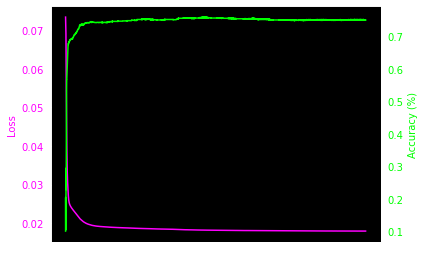

In [13]:
net = Model('categorical_crossentropy')
net.add(Dense(6, 20))
net.add(Activation('relu'))
net.add(Dense(20, 10))

history = net.fit(X_train, y_train, epochs=5000, lr=0.1)
test_metrics = net.evaluate(X_test, y_test)
print(f'Test set accuracy: {test_metrics[0]}; Test set loss: {test_metrics[1]}')
plot(history)

  0%|          | 0/5000 [00:00<?, ?it/s]

Test set accuracy: 0.7648902821316614; Test set loss: 0.018616820837854698


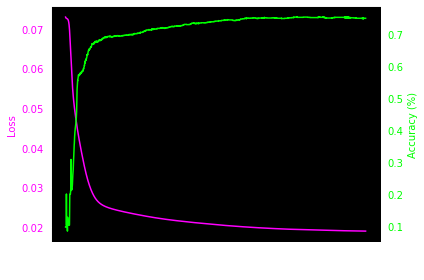

In [14]:
net = Model('categorical_crossentropy')
net.add(Dense(6, 20))
net.add(Activation('relu'))
net.add(Dense(20, 10))

history = net.fit(X_train, y_train, epochs=5000, lr=0.01)
test_metrics = net.evaluate(X_test, y_test)
print(f'Test set accuracy: {test_metrics[0]}; Test set loss: {test_metrics[1]}')
plot(history)

  0%|          | 0/5000 [00:00<?, ?it/s]

Test set accuracy: 0.6692789968652038; Test set loss: 0.029102515334895825


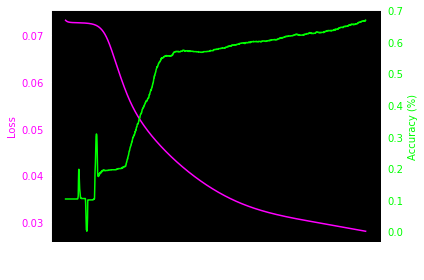

In [15]:
net = Model('categorical_crossentropy')
net.add(Dense(6, 20))
net.add(Activation('relu'))
net.add(Dense(20, 10))

history = net.fit(X_train, y_train, epochs=5000, lr=0.001)
test_metrics = net.evaluate(X_test, y_test)
print(f'Test set accuracy: {test_metrics[0]}; Test set loss: {test_metrics[1]}')
plot(history)

  0%|          | 0/5000 [00:00<?, ?it/s]

Test set accuracy: 0.7554858934169278; Test set loss: 0.022780810182775526


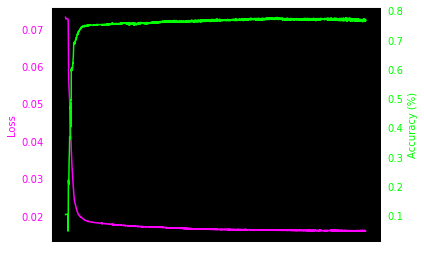

In [16]:
net = Model('categorical_crossentropy')
net.add(Dense(6, 20))
net.add(Activation('relu'))
net.add(Dense(20, 20))
net.add(Activation('relu'))
net.add(Dense(20, 10))

history = net.fit(X_train, y_train, epochs=5000, lr=0.1)
test_metrics = net.evaluate(X_test, y_test)
print(f'Test set accuracy: {test_metrics[0]}; Test set loss: {test_metrics[1]}')
plot(history)

  0%|          | 0/5000 [00:00<?, ?it/s]

Test set accuracy: 0.7617554858934169; Test set loss: 0.01831820351674667


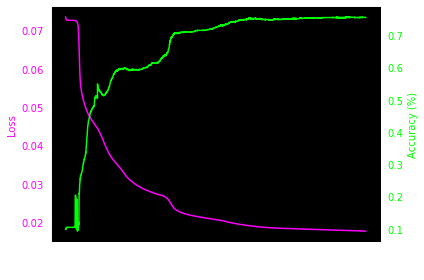

In [17]:
net = Model('categorical_crossentropy')
net.add(Dense(6, 20))
net.add(Activation('relu'))
net.add(Dense(20, 20))
net.add(Activation('relu'))
net.add(Dense(20, 10))

history = net.fit(X_train, y_train, epochs=5000, lr=0.01)
test_metrics = net.evaluate(X_test, y_test)
print(f'Test set accuracy: {test_metrics[0]}; Test set loss: {test_metrics[1]}')
plot(history)

  0%|          | 0/10000 [00:00<?, ?it/s]

Test set accuracy: 0.7304075235109718; Test set loss: 0.023381663670449398


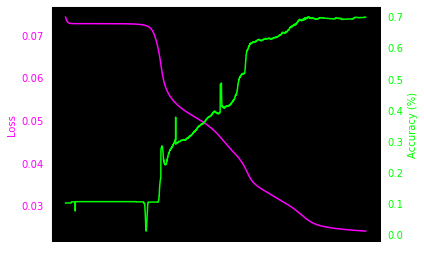

In [20]:
net = Model('categorical_crossentropy')
net.add(Dense(6, 20))
net.add(Activation('relu'))
net.add(Dense(20, 20))
net.add(Activation('relu'))
net.add(Dense(20, 10))

history = net.fit(X_train, y_train, epochs=10000, lr=0.001)
test_metrics = net.evaluate(X_test, y_test)
print(f'Test set accuracy: {test_metrics[0]}; Test set loss: {test_metrics[1]}')
plot(history)